In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
from sklearn import linear_model #modèle linéaire
from sklearn.metrics import mean_squared_error, r2_score #métriques d'évaluation

# Load the dataset
#data = pd.read_csv('data/test.csv', sep=";")
#data.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

In [3]:
#charger les données 
train = pd.read_csv("data/train.csv", sep=",")
test = pd.read_csv("data/test.csv", sep=",")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('Taille du dataset d entrainement {}.'.format(train.shape[0]))
print('Taille du dataset d entrainement {}.'.format(test.shape[0]))

Taille du dataset d entrainement 891.
Taille du dataset d entrainement 418.


<Axes: >

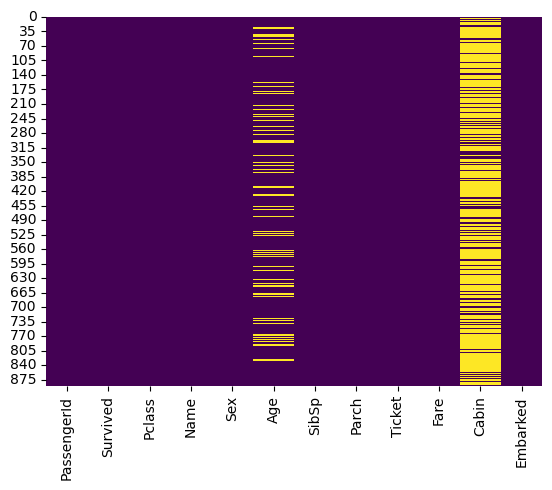

In [5]:
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')

In [6]:
# Calculate the percentage of NaN values in the "Age" column
print('Il y a %.2f%% d age qui manquent' %((train['Age'].isnull().sum()/train.shape[0])*100))

Il y a 19.87% d age qui manquent


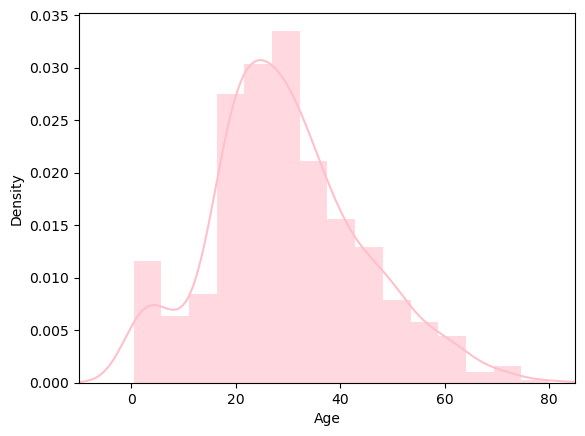

In [7]:
ax = train["Age"].hist(bins=15, density=True, stacked=True, color='pink', alpha=0.6)
train["Age"].plot(kind='density', color='pink')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [8]:

print('moyenne : %.2f' %(train["Age"].mean(skipna=True)))

print('medianne : %.2f' %(train["Age"].median(skipna=True)))

moyenne : 29.70
medianne : 28.00


In [9]:
print('Il y a %.2f%% de Cabin qui manquent' %((train['Cabin'].isnull().sum()/train.shape[0])*100))

Il y a 77.10% de Cabin qui manquent


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


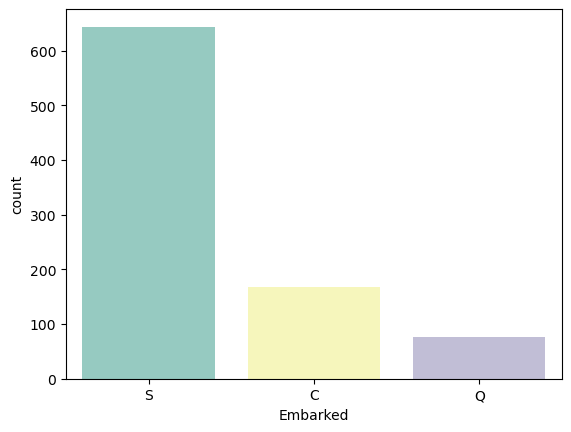

In [10]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train, palette='Set3')
plt.show()

### Define Train & Test data

Nous allons apporter les modifications suivantes aux données :
- Si l'âge ("Age") est manquant pour une ligne donnée, nous lui attribuerons la médiane 28 (âge médian).
- Si le lieu d'embarquement ("Embarked") est manquant pour une ligne donnée, nous lui attribuerons "S" (l'embarquement le plus courant).
- Nous ignorerons la cabine ("Cabin") en tant que variable. Il y a trop de valeurs manquantes, il n'aurait pas de sens de lui attribuer des valeurs.

In [11]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
train_modif = train.copy()
train_modif["Age"].fillna(train["Age"].median(skipna=True), inplace=True)
train_modif["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace=True)
train_modif.drop('Cabin', axis=1, inplace=True)

In [13]:
train_modif.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

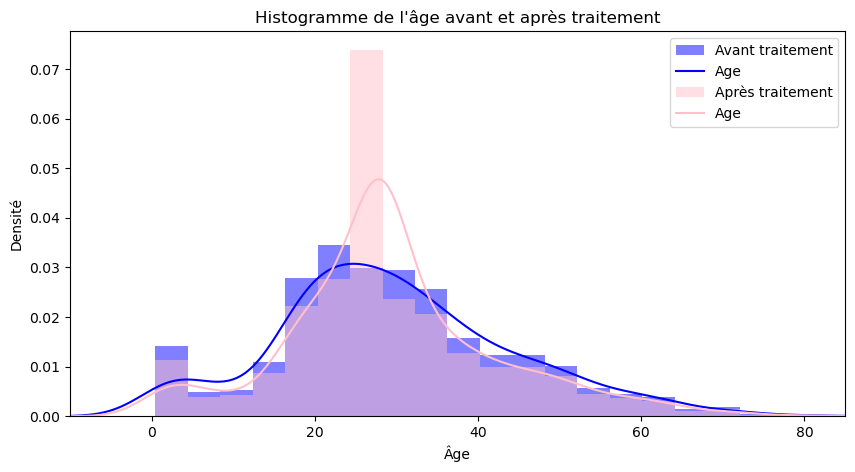

In [26]:
plt.figure(figsize=(10, 5))

plt.hist(train["Age"], bins=20, color='blue', density=True, stacked=True, alpha=0.5, label='Avant traitement')
train["Age"].plot(kind='density', color='blue')

plt.hist(train_modif["Age"], bins=20, color='pink', density=True, stacked=True, alpha=0.5, label='Après traitement')
train_modif["Age"].plot(kind='density', color='pink')


plt.title("Histogramme de l'âge avant et après traitement")
plt.xlabel("Âge")
plt.ylabel("Densité")

plt.xlim(-10,85)

plt.legend()
plt.show()

### Feature engineering

In [27]:
train_modif['TravelAlone']=np.where((train_modif["SibSp"]+train_modif["Parch"])>0, 0, 1)

In [29]:
train_modif.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TravelAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


In [32]:
dummie = pd.get_dummies(train_modif, columns=["Pclass","Embarked","Sex"])
dummie.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,0,0,1,0,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,1,0,0,1,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,1,0,0,1,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,1,0,0,0,0,1,1,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,0,1,0,0,1,0,1


In [35]:
dummie.drop('PassengerId', axis=1, inplace=True)
dummie.drop('Name', axis=1, inplace=True)
dummie.drop('SibSp', axis=1, inplace=True)
dummie.drop('Parch', axis=1, inplace=True)
dummie.drop('Sex_female', axis=1, inplace=True)

dummie.head()

,Survived,Age,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,A/5 21171,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,PC 17599,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,STON/O2. 3101282,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,113803,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,373450,8.0500,1,0,0,1,0,0,1,1


In [38]:
dummie.drop('Ticket', axis=1,inplace=True)
dummie.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


### Do the same with the test dataset

In [36]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [37]:
test_modif = test.copy()
test_modif["Age"].fillna(test["Age"].median(skipna=True), inplace=True)
test_modif["Embarked"].fillna(test['Embarked'].value_counts().idxmax(), inplace=True)
test_modif.drop('Cabin', axis=1, inplace=True)

test_modif.isnull().sum()

test_modif['TravelAlone']=np.where((test_modif["SibSp"]+test_modif["Parch"])>0, 0, 1)

dummieTest = pd.get_dummies(test_modif, columns=["Pclass","Embarked","Sex"])
dummieTest.head()
dummieTest.drop('PassengerId', axis=1, inplace=True)
dummieTest.drop('Name', axis=1, inplace=True)
dummieTest.drop('SibSp', axis=1, inplace=True)
dummieTest.drop('Parch', axis=1, inplace=True)
dummieTest.drop('Sex_female', axis=1, inplace=True)

dummieTest.head()

,Age,Ticket,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,330911,7.8292,1,0,0,1,0,1,0,1
1,47.0,363272,7.0000,0,0,0,1,0,0,1,0
2,62.0,240276,9.6875,1,0,1,0,0,1,0,1
3,27.0,315154,8.6625,1,0,0,1,0,0,1,1
4,22.0,3101298,12.2875,0,0,0,1,0,0,1,0


In [39]:
dummieTest.drop('Ticket', axis=1,inplace=True)
dummieTest.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


### Exploratory Data Analysis

##### Age

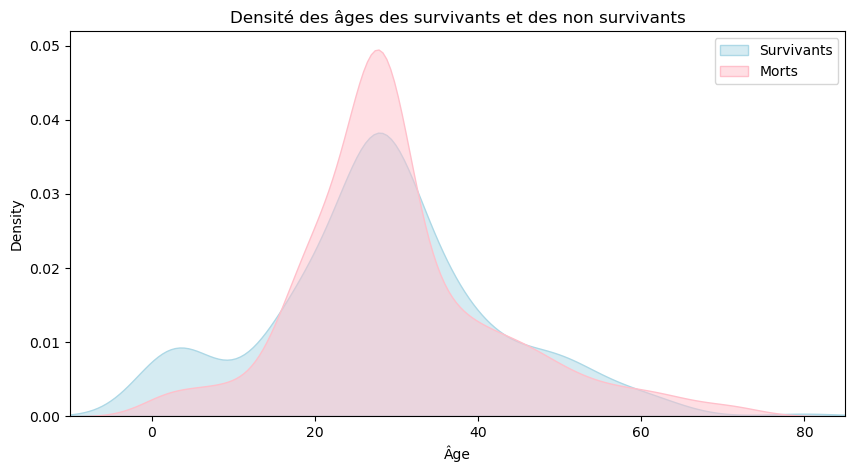

In [61]:
plt.figure(figsize=(10, 5))

sns.kdeplot(dummie["Age"][dummie.Survived == 1], color="lightblue", fill=True, alpha=0.5)
sns.kdeplot(dummie["Age"][dummie.Survived == 0], color="pink", fill=True, alpha=0.5)

plt.legend(['Survivants', 'Morts'])
plt.title('Densité des âges des survivants et des non survivants')
plt.xlabel("Âge")
plt.xlim(-10, 85)
plt.show()


In [66]:
dummie['IsMinor']=np.where((train_modif["Age"])<16, 1, 0)


### Passenger Class

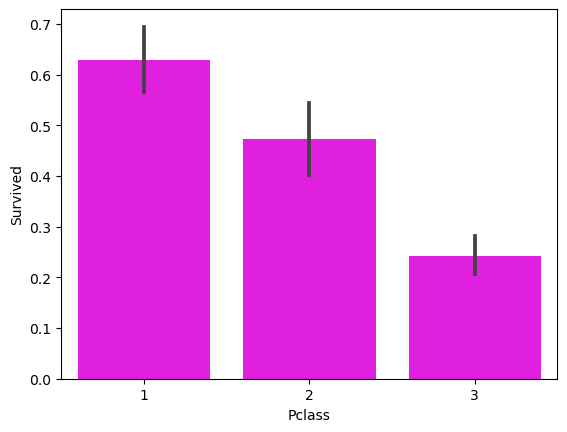

In [74]:
sns.barplot(x='Pclass', y='Survived', data=train, color="magenta")
plt.show()

### Embarked Port

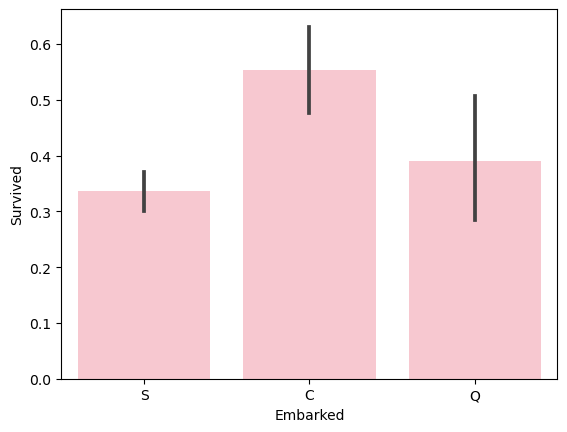

In [75]:
sns.barplot(x='Embarked', y='Survived', data=train, color="pink")
plt.show()

### Traveling Alone vs. With Family

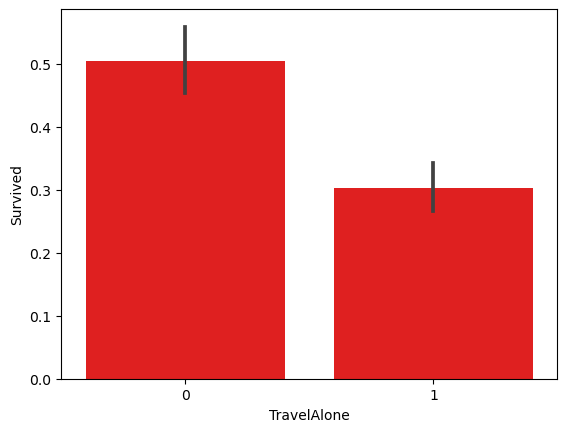

In [77]:
sns.barplot(x='TravelAlone', y='Survived', data=train_modif, color="red")
plt.show()

### Gender Variable

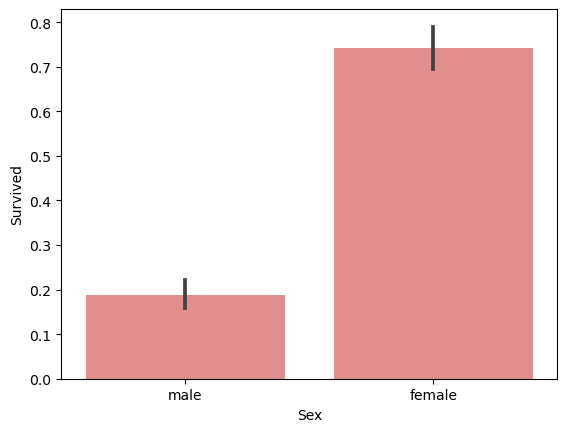

In [81]:
sns.barplot(x='Sex', y='Survived', data=train, color="lightcoral")
plt.show()

#### Logistic Regression with scikit-learn

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [199]:
#define x and y for the model
element = ['Age','Fare','TravelAlone','Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_S','Embarked_Q','Sex_male','IsMinor',]
X = dummie[element]
Y = dummie['Survived']

In [200]:
#instanciate a LogisticRegression estimator in sklearn
logreg = LogisticRegression(max_iter=1000)

In [201]:
# Create a RFE model and select 4 attributes
rfe = RFE(logreg, n_features_to_select=4)
rfe.fit(X, Y)
selection = X.columns[rfe.support_]
print("Les features sélectionnées:", selection)

Les features sélectionnées: Index(['Pclass_1', 'Pclass_3', 'Embarked_S', 'Sex_male'], dtype='object')


In [202]:
#create a RFE model and select 8 atribute
rfe = RFE(logreg, n_features_to_select=8)
rfe.fit(X,Y)
selection2 = X.columns[rfe.support_]
print("Les features séléctionnée :", selection2 )

Les features séléctionnée : Index(['Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_S',
       'Embarked_Q', 'Sex_male'],
      dtype='object')


#### Feature ranking with recursive feature elimination and cross-validation

In [203]:
#instantiate an RFECV object (with a scoring='accuracy') and do as stated above
rfecv = RFECV(logreg, scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal nombre de features :", rfecv.n_features_)
print("Les features séléctionnée :", X.columns[rfecv.support_])


Optimal nombre de features : 9
Les features séléctionnée : Index(['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Sex_male'],
      dtype='object')


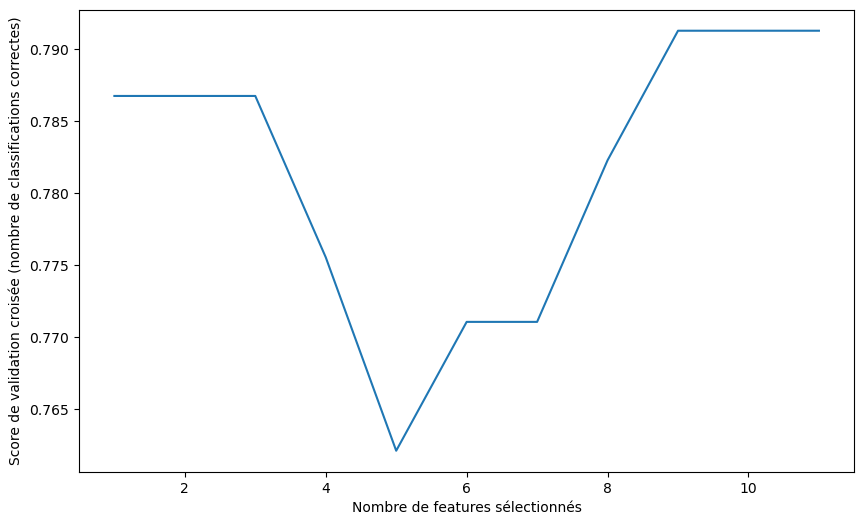

In [205]:
#cols = ["Age", "Fare", "TravelAlone", "Pclass_1", "Pclass_2", "Embarked_C", "Embarked_S", "Sex_male", "IsMinor"]
#X = dummie[cols]
#y = dummie['Survived']
#rfecv = RFECV(estimator=LogisticRegression(max_iter=300),scoring='accuracy')
#rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Nombre de features sélectionnés")
plt.ylabel("Score de validation croisée (nombre de classifications correctes)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


#### Roll back on our model and evaluate metrics

In [215]:
#create the new dataframe and print the shape
Ntrain = dummie.copy()
Ntest = dummieTest.copy()

element = ['Age','Fare','TravelAlone','Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_S','Embarked_Q','Sex_male','IsMinor',]
X = Ntrain[element]

selected_features = X[X.columns[rfecv.support_]]

# Print the shape of the new DataFrame
print("Shape of the new DataFrame:", selected_features.shape)
print("Shape of the target variable:", y.shape)


Shape of the new DataFrame: (891, 9)
Shape of the target variable: (891,)


In [216]:
#split your data with an alpha=20% and a random_state=42
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
from sklearn.linear_model import LogisticRegression

# Instantiate the LogisticRegression model
logreg = LogisticRegression(max_iter = 1000)

# Fit the model on your training data
logreg.fit(X_train, y_train)


Intercept: [2.08815394]


In [220]:
# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Print the predicted labels
print("Predicted labels:", y_pred)


Predicted labels: [0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1]


In [222]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# Make probability predictions on the test set
y_prob = logreg.predict_proba(X_test)

# Extract predicted probabilities for the positive class (Survived)
y_prob_positive = y_prob[:, 1]

# Make binary predictions based on predicted probabilities
y_pred = y_prob_positive > 0.5

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate log loss
logloss = log_loss(y_test, y_prob)
print("Log Loss:", logloss)

# Calculate AUC
auc = roc_auc_score(y_test, y_prob_positive)
print("AUC:", auc)


Accuracy: 0.7877094972067039
Log Loss: 0.42993431874038535
AUC: 0.8758043758043758
